In [1]:
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import shap
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import pickle


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Data Preparation

In [2]:
df = pd.read_csv('../Data/STAGE 4 FINAL MERGED DATA/STAGE_4_MERGED_FINAL_ENCODED.csv')

In [3]:
df

,klasifikasi_perkara_encoded,penuntut_umum_encoded,hakim_encoded,jumlah_saksi,maks_penjara_berdasarkan_pasal,terdakwa,summarized_dakwaan,total_pidana_penjara_bulan
0,0,0,0,6,80,GEDE DARMAYASA,Terdakwa Gede Darmayasa didakwa telah melakuka...,5.0
1,1,1,1,4,48,IDA BAGUS MADE DARMA WIGUNA,"Pada bulan Februari dan Maret 2024, terdakwa I...",24.0
2,0,0,2,6,84,HANDRI JOHANAS,"Terdakwa Handri Johanes pada Rabu, 24 April 20...",4.0
3,2,2,1,2,144,I GEDE ARIADI alias BERNAD,"Pada hari Minggu, 14 April 2024 sekitar pukul ...",14.0
4,2,3,1,2,144,I GEDE ARIADI alias BERNAD,"Pada hari Minggu, 14 April 2024 sekitar pukul ...",14.0
...,...,...,...,...,...,...,...,...
4318,2,276,128,2,240,NURUL FIQRI SUDIRMAN als KIKI bin SUDIRMAN,"Pada Jumat, 31 Maret 2023, sekitar pukul 20.30...",72.0
4319,0,264,117,2,84,SUPRIADI BIN RATIM,"Pada hari Minggu, 28 Mei 2023, sekitar pukul 1...",16.0
4320,0,287,117,2,84,SUPRIADI BIN RATIM,"Pada hari Minggu, 28 Mei 2023, sekitar pukul 1...",16.0
4321,0,264,117,2,84,ANWAR RURI BIN SYARIFUDIN USMAN,"Pada hari Minggu, 28 Mei 2023, sekitar pukul 1...",16.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4323 entries, 0 to 4322
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   klasifikasi_perkara_encoded     4323 non-null   int64  
 1   penuntut_umum_encoded           4323 non-null   int64  
 2   hakim_encoded                   4323 non-null   int64  
 3   jumlah_saksi                    4323 non-null   int64  
 4   maks_penjara_berdasarkan_pasal  4323 non-null   int64  
 5   terdakwa                        4323 non-null   object 
 6   summarized_dakwaan              4323 non-null   object 
 7   total_pidana_penjara_bulan      4323 non-null   float64
dtypes: float64(1), int64(5), object(2)
memory usage: 270.3+ KB


### Split Data

In [5]:
def stratified_split(df: pd.DataFrame, split_size: float = 0.8) -> tuple[pd.DataFrame, pd.DataFrame]:
    unique_groups = df.groupby(["klasifikasi_perkara_encoded", "penuntut_umum_encoded", "hakim_encoded"]).apply(lambda x: x.index.tolist()).to_dict()
    
    print(unique_groups)
    train_idx, test_idx = [], []
    
    for indices in unique_groups.values():        
        if len(indices) == 1:
            train_idx.extend(indices)
        else:
            train, test = train_test_split(indices, train_size=split_size, random_state=42)
            train_idx.extend(train)
            test_idx.extend(test)
    
    return df.loc[train_idx], df.loc[test_idx]

In [6]:
train_df, test_df = stratified_split(df)

{(0, 0, 0): [0, 20, 42], (0, 0, 2): [2], (0, 1, 0): [19, 37], (0, 1, 4): [35, 36], (0, 4, 1): [5], (0, 4, 3): [10], (0, 5, 21): [843], (0, 7, 1): [9], (0, 8, 0): [15, 17], (0, 9, 0): [16, 18], (0, 11, 4): [22, 23], (0, 12, 19): [775, 776, 813], (0, 12, 21): [774], (0, 12, 22): [715], (0, 12, 23): [806], (0, 13, 0): [32], (0, 13, 3): [34], (0, 14, 0): [38], (0, 14, 14): [437, 501, 595, 609], (0, 14, 16): [422], (0, 14, 18): [474, 665], (0, 14, 19): [783, 784, 785, 786], (0, 14, 20): [432, 438, 518, 578, 608, 724, 745], (0, 14, 21): [639, 822], (0, 15, 4): [33], (0, 16, 0): [39], (0, 17, 0): [40, 41], (0, 19, 7): [46], (0, 20, 37): [1051], (0, 21, 55): [1612], (0, 21, 57): [1630, 1632], (0, 22, 10): [241, 268, 269, 270, 271, 303], (0, 22, 14): [259, 381, 415, 416, 538, 545, 577, 621], (0, 22, 16): [308, 314, 315, 383, 386, 417], (0, 22, 18): [654, 655, 656], (0, 22, 19): [548, 762], (0, 22, 20): [446, 570, 571, 572, 573, 690, 725], (0, 22, 22): [719], (0, 23, 10): [52, 54], (0, 24, 10): 

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [7]:
jenis_klasifikasi_perkara = train_df['klasifikasi_perkara_encoded'].unique()
jumlah_klasifikasi_perkara = len(jenis_klasifikasi_perkara)
print(f"Jumlah Klasifikasi Perkara: {jumlah_klasifikasi_perkara}")
print(f"Jumlah Data Train:  {len(train_df)}")

klasifikasi_perkara_values = train_df['klasifikasi_perkara_encoded'].value_counts()
print(klasifikasi_perkara_values)

Jumlah Klasifikasi Perkara: 5
Jumlah Data Train:  3273
klasifikasi_perkara_encoded
0    1378
2    1251
3     289
4     193
1     162
Name: count, dtype: int64


In [8]:
jenis_klasifikasi_perkara = test_df['klasifikasi_perkara_encoded'].unique()
jumlah_klasifikasi_perkara = len(jenis_klasifikasi_perkara)
print(f"Jumlah Klasifikasi Perkara: {jumlah_klasifikasi_perkara}")
print(f"Jumlah Data Test:  {len(test_df)}")

klasifikasi_perkara_values = test_df['klasifikasi_perkara_encoded'].value_counts()
print(klasifikasi_perkara_values)

Jumlah Klasifikasi Perkara: 5
Jumlah Data Test:  1050
klasifikasi_perkara_encoded
0    490
2    438
4     51
3     48
1     23
Name: count, dtype: int64


## Model

In [9]:
model_scenario_name = "BiLSTM_13"
max_len = 1024

model_save_path = f'../Model/{model_scenario_name}'
tokenizer_save_path = f'../Model/{model_scenario_name}_tokenizer.pkl'
history_training_save_path = f'../Model/{model_scenario_name}_training_history.pkl'
    
loaded_model = tf.keras.models.load_model(model_save_path)

with open(tokenizer_save_path, 'rb') as handle:
    tokenizer = pickle.load(handle)

### Model Preprocessing

In [10]:
train_df['concat_text'] = train_df[['terdakwa', 'summarized_dakwaan']].apply(lambda x: '. '.join(x), axis=1)
test_df['concat_text'] = test_df[['terdakwa', 'summarized_dakwaan']].apply(lambda x: '. '.join(x), axis=1)

In [11]:
y_train = train_df['total_pidana_penjara_bulan']
y_test = test_df['total_pidana_penjara_bulan']

### Normalisasi

In [12]:
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train_df['normalized_text'] = train_df['concat_text'].apply(normalize_text)
test_df['normalized_text'] = test_df['concat_text'].apply(normalize_text)

### Stopwords Removal

In [13]:
nltk.download('stopwords')

stop_words = set(stopwords.words('indonesian'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

train_df['stopword_removal'] = train_df['normalized_text'].apply(remove_stopwords)
test_df['stopword_removal'] = test_df['normalized_text'].apply(remove_stopwords)

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


### Stemming

In [14]:
stemmer = PorterStemmer()

def stem_text(text):
    return ' '.join([stemmer.stem(word) for word in text.split()])

train_df['stemmed_text'] = train_df['stopword_removal'].apply(stem_text)
test_df['stemmed_text'] = test_df['stopword_removal'].apply(stem_text)

### SHAP

In [15]:
# Ambil 20 data acak dari setiap klasifikasi_perkara
train_sampled_bg_df = (
    train_df.groupby('klasifikasi_perkara_encoded', group_keys=False)
      .apply(lambda x: x.sample(n=20, random_state=7))
)

train_sampled_bg_df = train_sampled_bg_df.reset_index(drop=True)

text_train_sampled_bg_df = train_sampled_bg_df['stemmed_text']
numerical_train_sampled_bg_df = train_sampled_bg_df[['klasifikasi_perkara_encoded', 'penuntut_umum_encoded', 'hakim_encoded', 'jumlah_saksi', 'maks_penjara_berdasarkan_pasal']].values

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [16]:
train_sampled_bg_df

,klasifikasi_perkara_encoded,penuntut_umum_encoded,hakim_encoded,jumlah_saksi,maks_penjara_berdasarkan_pasal,terdakwa,summarized_dakwaan,total_pidana_penjara_bulan,concat_text,normalized_text,stopword_removal,stemmed_text
0,0,88,31,3,84,Rudolf Dule Robo Als. Roni,"Terdakwa 1, RUDOLF DULE ROBO alias RONI, bersa...",24.0,"Rudolf Dule Robo Als. Roni. Terdakwa 1, RUDOLF...",rudolf dule robo als roni terdakwa rudolf dule...,rudolf dule robo als roni terdakwa rudolf dule...,rudolf dule robo al roni terdakwa rudolf dule ...
1,0,192,82,3,60,Desak Komang Ayu Pratiwi Alias Desak,Terdakwa Desak Komang Ayu Pratiwi alias Desak ...,5.0,Desak Komang Ayu Pratiwi Alias Desak. Terdakwa...,desak komang ayu pratiwi alias desak terdakwa ...,desak komang ayu pratiwi alias desak terdakwa ...,desak komang ayu pratiwi alia desak terdakwa d...
2,0,12,19,5,112,Samsul Arifin,Bahwa Terdakwa Samsul Arifin pada bulan Juli d...,18.0,Samsul Arifin. Bahwa Terdakwa Samsul Arifin pa...,samsul arifin bahwa terdakwa samsul arifin pad...,samsul arifin terdakwa samsul arifin juli nove...,samsul arifin terdakwa samsul arifin juli nove...
3,0,52,14,3,84,TAUFAN AHMAD GHOFIQI alias TAUFAN,Bahwa Terdakwa I. TAUFAN AHMAD GHOFIQI alias T...,12.0,TAUFAN AHMAD GHOFIQI alias TAUFAN. Bahwa Terda...,taufan ahmad ghofiqi alias taufan bahwa terdak...,taufan ahmad ghofiqi alias taufan terdakwa i t...,taufan ahmad ghofiqi alia taufan terdakwa i ta...
4,0,143,49,5,144,IMAM ANWAR,Terdakwa Imam Anwar Als Imam bersama dengan sa...,30.0,IMAM ANWAR. Terdakwa Imam Anwar Als Imam bersa...,imam anwar terdakwa imam anwar als imam bersam...,imam anwar terdakwa imam anwar als imam saksi ...,imam anwar terdakwa imam anwar al imam saksi n...
...,...,...,...,...,...,...,...,...,...,...,...,...
95,4,74,18,2,120,I Wayan Dastra,"Pada hari Minggu, 29 Juli 2018 sekitar pukul 1...",6.0,"I Wayan Dastra. Pada hari Minggu, 29 Juli 2018...",i wayan dastra pada hari minggu juli sekitar p...,i wayan dastra minggu juli wita terdakwa i nyo...,i wayan dastra minggu juli wita terdakwa i nyo...
96,4,73,18,2,120,I NYOMAN JAYA,"Pada hari Rabu, 3 Oktober 2018 sekitar pukul 2...",3.0,"I NYOMAN JAYA. Pada hari Rabu, 3 Oktober 2018 ...",i nyoman jaya pada hari rabu oktober sekitar p...,i nyoman jaya rabu oktober wita bertempat want...,i nyoman jaya rabu oktob wita bertempat wantil...
97,4,266,129,2,120,YUDA DARUS DEPRIYANUS,"Pada hari Minggu, 09 Juli 2023, sekitar pukul ...",8.0,"YUDA DARUS DEPRIYANUS. Pada hari Minggu, 09 Ju...",yuda darus depriyanus pada hari minggu juli se...,yuda darus depriyanus minggu juli wib anggota ...,yuda daru depriyanu minggu juli wib anggota po...
98,4,73,75,4,120,Kadek Juniarta alias Tombro,"Pada hari Minggu, tanggal 15 Agustus 2021, sek...",3.0,"Kadek Juniarta alias Tombro. Pada hari Minggu,...",kadek juniarta alias tombro pada hari minggu t...,kadek juniarta alias tombro minggu tanggal agu...,kadek juniarta alia tombro minggu tanggal agus...


In [17]:
# Ambil 10 data acak dari setiap klasifikasi_perkara
test_sampled_df = (
    test_df.groupby('klasifikasi_perkara_encoded', group_keys=False)
      .apply(lambda x: x.sample(n=6, random_state=7))
)

test_sampled_df = test_sampled_df.reset_index(drop=True)

text_test_sampled_bg_df = test_sampled_df['stemmed_text']
numerical_test_sampled_bg_df = test_sampled_df[['klasifikasi_perkara_encoded', 'penuntut_umum_encoded', 'hakim_encoded', 'jumlah_saksi', 'maks_penjara_berdasarkan_pasal']].values

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [18]:
test_sampled_df

,klasifikasi_perkara_encoded,penuntut_umum_encoded,hakim_encoded,jumlah_saksi,maks_penjara_berdasarkan_pasal,terdakwa,summarized_dakwaan,total_pidana_penjara_bulan,concat_text,normalized_text,stopword_removal,stemmed_text
0,0,205,73,5,84,ARIONO,"Pada hari Sabtu, 4 Mei 2024 sekitar pukul 21.0...",9.000000,"ARIONO. Pada hari Sabtu, 4 Mei 2024 sekitar pu...",ariono pada hari sabtu mei sekitar pukul wita ...,ariono sabtu mei wita bertempat banjar dinas p...,ariono sabtu mei wita bertempat banjar dina pa...
1,0,47,14,3,84,SURIYANTO Alias YANTO,"Pada Selasa, 31 Januari 2023 sekitar pukul 15....",18.000000,"SURIYANTO Alias YANTO. Pada Selasa, 31 Januari...",suriyanto alias yanto pada selasa januari seki...,suriyanto alias yanto selasa januari wita terd...,suriyanto alia yanto selasa januari wita terda...
2,0,273,119,2,144,ILHAM WAHYUDI SAPUTRA Bin DUKRI,"Pada hari Minggu, 7 Januari 2024, sekitar puku...",15.000000,ILHAM WAHYUDI SAPUTRA Bin DUKRI. Pada hari Min...,ilham wahyudi saputra bin dukri pada hari ming...,ilham wahyudi saputra bin dukri minggu januari...,ilham wahyudi saputra bin dukri minggu januari...
3,0,143,49,4,60,I GUSTI PUTU ATMAJA,"Terdakwa I Gusti Putu Atmaja pada hari Sabtu, ...",12.000000,I GUSTI PUTU ATMAJA. Terdakwa I Gusti Putu Atm...,i gusti putu atmaja terdakwa i gusti putu atma...,i gusti putu atmaja terdakwa i gusti putu atma...,i gusti putu atmaja terdakwa i gusti putu atma...
4,0,41,16,4,112,SALAMAN Alias MAMAN,"Pada tanggal 31 Agustus 2021 dini hari, para t...",14.000000,SALAMAN Alias MAMAN. Pada tanggal 31 Agustus 2...,salaman alias maman pada tanggal agustus dini ...,salaman alias maman tanggal agustus terdakwa i...,salaman alia maman tanggal agustu terdakwa i k...
5,0,168,51,4,60,FATHURRAHMAN,"Bahwa Terdakwa FATHURRAHMAN, pada hari Senin t...",8.000000,"FATHURRAHMAN. Bahwa Terdakwa FATHURRAHMAN, pad...",fathurrahman bahwa terdakwa fathurrahman pada ...,fathurrahman terdakwa fathurrahman senin tangg...,fathurrahman terdakwa fathurrahman senin tangg...
6,1,25,18,6,48,I NYOMAN SUTEJA,Terdakwa I Nyoman Suteja didakwa telah melakuk...,20.000000,I NYOMAN SUTEJA. Terdakwa I Nyoman Suteja dida...,i nyoman suteja terdakwa i nyoman suteja didak...,i nyoman suteja terdakwa i nyoman suteja didak...,i nyoman suteja terdakwa i nyoman suteja didak...
7,1,63,21,6,48,I GUSTI NGURAH YASA alias GUSTI NGURAH SEMER,Terdakwa I Gusti Ngurah Yasa alias Gusti Ngura...,18.000000,I GUSTI NGURAH YASA alias GUSTI NGURAH SEMER. ...,i gusti ngurah yasa alias gusti ngurah semer t...,i gusti ngurah yasa alias gusti ngurah semer t...,i gusti ngurah yasa alia gusti ngurah semer te...
8,1,58,14,4,48,ZAINAL ARIFIN,Bahwa pada hari Kamis tanggal 30 Juni 2022 sek...,27.000000,ZAINAL ARIFIN. Bahwa pada hari Kamis tanggal 3...,zainal arifin bahwa pada hari kamis tanggal ju...,zainal arifin kamis tanggal juni wita bertempa...,zainal arifin kami tanggal juni wita bertempat...
9,1,293,126,2,84,SUHENDRI Bin ANDI SUPRIAYADI,"Terdakwa SUHENDRI bin ANDI SUPRIAYADI, bersama...",20.000000,SUHENDRI Bin ANDI SUPRIAYADI. Terdakwa SUHENDR...,suhendri bin andi supriayadi terdakwa suhendri...,suhendri bin andi supriayadi terdakwa suhendri...,suhendri bin andi supriayadi terdakwa suhendri...


### Tokenizer

In [19]:
# Tokenisasi
text_train_sequences = tokenizer.texts_to_sequences(text_train_sampled_bg_df)
text_test_sequences = tokenizer.texts_to_sequences(text_test_sampled_bg_df)

In [20]:
# Padding
max_len = 1024
X_text_train = tf.keras.preprocessing.sequence.pad_sequences(text_train_sequences, maxlen=max_len, padding='post', truncating='post')
X_text_test = tf.keras.preprocessing.sequence.pad_sequences(text_test_sequences, maxlen=max_len, padding='post', truncating='post')

In [21]:
np.shape(X_text_test)

(30, 1024)

In [22]:
numerical_test_sampled_bg_df

array([[  0, 205,  73,   5,  84],
       [  0,  47,  14,   3,  84],
       [  0, 273, 119,   2, 144],
       [  0, 143,  49,   4,  60],
       [  0,  41,  16,   4, 112],
       [  0, 168,  51,   4,  60],
       [  1,  25,  18,   6,  48],
       [  1,  63,  21,   6,  48],
       [  1,  58,  14,   4,  48],
       [  1, 293, 126,   2,  84],
       [  1, 282, 128,   2,  48],
       [  1, 265, 121,   2,  48],
       [  2, 258,  99,   1, 240],
       [  2, 265, 136,   2, 240],
       [  2,  65,  14,   4, 240],
       [  2,  62,  19,   3, 144],
       [  2, 278, 120,   2, 240],
       [  2, 265, 134,   2, 240],
       [  3, 214,  84,   4,  48],
       [  3, 216,  84,   5,  48],
       [  3, 265, 118,   2,  60],
       [  3, 276, 121,   2,  48],
       [  3, 278, 123,   2,  48],
       [  3, 265, 122,   2,  60],
       [  4, 203,  86,   2, 120],
       [  4, 192,  86,   2, 120],
       [  4,  66,  19,   3, 120],
       [  4,  73,  83,   2, 120],
       [  4,  73,  75,   4, 120],
       [  4, 1

In [23]:
X_background = np.concatenate([X_text_train, numerical_train_sampled_bg_df], axis=1)

X_text_test = X_text_test
X_num_test = numerical_test_sampled_bg_df
X_test = np.concatenate([X_text_test, X_num_test], axis=1)

def model_predict(x):
    # Pisahkan: panjang teks = 1024
    text_input = x[:, :1024].astype(int)
    num_input = x[:, 1024:].astype(np.float32)
    return loaded_model.predict([text_input, num_input])

explainer = shap.KernelExplainer(model_predict, X_background)
shap_values = explainer.shap_values(X_test)

4/4 [==============================] - 3s 99ms/step


  0%|          | 0/30 [00:00<?, ?it/s]

8594/8594 [==============================] - 897s 104ms/step


  3%|▎         | 1/30 [15:02<7:16:13, 902.53s/it]

8594/8594 [==============================] - 918s 107ms/step


  7%|▋         | 2/30 [30:24<7:06:36, 914.17s/it]

8594/8594 [==============================] - 925s 108ms/step


 10%|█         | 3/30 [45:54<6:54:29, 921.09s/it]

8594/8594 [==============================] - 924s 107ms/step


 13%|█▎        | 4/30 [1:01:21<6:40:16, 923.71s/it]

8594/8594 [==============================] - 927s 108ms/step


 17%|█▋        | 5/30 [1:16:52<6:25:58, 926.36s/it]

8594/8594 [==============================] - 927s 108ms/step


 20%|██        | 6/30 [1:32:24<6:11:13, 928.07s/it]

8594/8594 [==============================] - 908s 106ms/step


 23%|██▎       | 7/30 [1:47:36<5:53:49, 923.01s/it]

8594/8594 [==============================] - 922s 107ms/step


 27%|██▋       | 8/30 [2:03:03<5:38:50, 924.14s/it]

8594/8594 [==============================] - 925s 108ms/step


 30%|███       | 9/30 [2:18:32<5:24:00, 925.73s/it]

8594/8594 [==============================] - 926s 108ms/step


 33%|███▎      | 10/30 [2:34:02<5:08:59, 926.97s/it]

8594/8594 [==============================] - 925s 108ms/step


 37%|███▋      | 11/30 [2:49:31<4:53:43, 927.55s/it]

8594/8594 [==============================] - 929s 108ms/step


 40%|████      | 12/30 [3:05:04<4:38:45, 929.17s/it]

8594/8594 [==============================] - 927s 108ms/step


 43%|████▎     | 13/30 [3:20:35<4:23:24, 929.70s/it]

8594/8594 [==============================] - 924s 108ms/step


 47%|████▋     | 14/30 [3:36:03<4:07:50, 929.39s/it]

8594/8594 [==============================] - 928s 108ms/step


 50%|█████     | 15/30 [3:51:36<3:52:35, 930.37s/it]

8594/8594 [==============================] - 928s 108ms/step


 53%|█████▎    | 16/30 [4:07:09<3:37:14, 931.05s/it]

8594/8594 [==============================] - 929s 108ms/step


 57%|█████▋    | 17/30 [4:22:42<3:21:52, 931.72s/it]

8594/8594 [==============================] - 926s 108ms/step


 60%|██████    | 18/30 [4:38:12<3:06:14, 931.17s/it]

8594/8594 [==============================] - 929s 108ms/step


 63%|██████▎   | 19/30 [4:53:46<2:50:51, 931.95s/it]

8594/8594 [==============================] - 929s 108ms/step


 67%|██████▋   | 20/30 [5:09:19<2:35:24, 932.47s/it]

8594/8594 [==============================] - 928s 108ms/step


 70%|███████   | 21/30 [5:24:53<2:19:54, 932.73s/it]

8594/8594 [==============================] - 930s 108ms/step


 73%|███████▎  | 22/30 [5:40:28<2:04:27, 933.46s/it]

8594/8594 [==============================] - 932s 108ms/step


 77%|███████▋  | 23/30 [5:56:04<1:49:01, 934.43s/it]

8594/8594 [==============================] - 928s 108ms/step


 80%|████████  | 24/30 [6:11:37<1:33:22, 933.78s/it]

8594/8594 [==============================] - 924s 108ms/step


 83%|████████▎ | 25/30 [6:27:05<1:17:40, 932.15s/it]

8594/8594 [==============================] - 926s 108ms/step


 87%|████████▋ | 26/30 [6:42:35<1:02:06, 931.56s/it]

8594/8594 [==============================] - 932s 108ms/step


 90%|█████████ | 27/30 [6:58:11<46:38, 932.84s/it]  

8594/8594 [==============================] - 931s 108ms/step


 93%|█████████▎| 28/30 [7:13:46<31:06, 933.41s/it]

8594/8594 [==============================] - 929s 108ms/step


 97%|█████████▋| 29/30 [7:29:19<15:33, 933.47s/it]

8594/8594 [==============================] - 930s 108ms/step


100%|██████████| 30/30 [7:44:54<00:00, 929.80s/it]


In [24]:
# Save shap_values 
with open('shap_values_BiLSTM_13.pkl', 'wb') as f:
    pickle.dump(shap_values, f)

In [25]:
with open('shap_values_BiLSTM_13.pkl', 'rb') as f:
    shap_values = pickle.load(f)

In [26]:
shap_values

[array([[ 0.10160506,  0.07744456,  0.08523749, ..., -0.31484266,
         -0.23960469, -3.31858379],
        [-0.06889678,  0.12946298,  0.11208935, ..., -1.23001039,
         -0.09440824, -3.14975735],
        [ 0.19048745, -0.09378221, -0.16090472, ...,  0.64139773,
          0.28099922, -0.16366048],
        ...,
        [-0.04324221, -0.20074049,  0.12444699, ..., -0.10843007,
         -0.27702229, -3.91630732],
        [ 0.        , -0.06345322,  0.        , ..., -0.43615256,
          0.23154699, -3.94968386],
        [ 0.        , -0.21003324, -0.20084671, ..., -1.00260756,
          0.31279292, -3.09673526]])]

In [27]:
print(type(shap_values))
print(len(shap_values) if isinstance(shap_values, (list, tuple)) else 'not list/tuple')
print([arr.shape for arr in shap_values] if isinstance(shap_values, (list, tuple)) else shap_values.shape)


<class 'list'>
1
[(30, 1029)]


In [28]:
# jumlah fitur teks 1024
num_text_features = 1024

# fitur token
feature_names_text = [f'token_{i}' for i in range(num_text_features)]

# nama fitur numerik
feature_names_num = ['klasifikasi_perkara', 'penuntut_umum', 'hakim', 'jumlah_saksi', 'maks_penjara']

feature_names_all = feature_names_text + feature_names_num


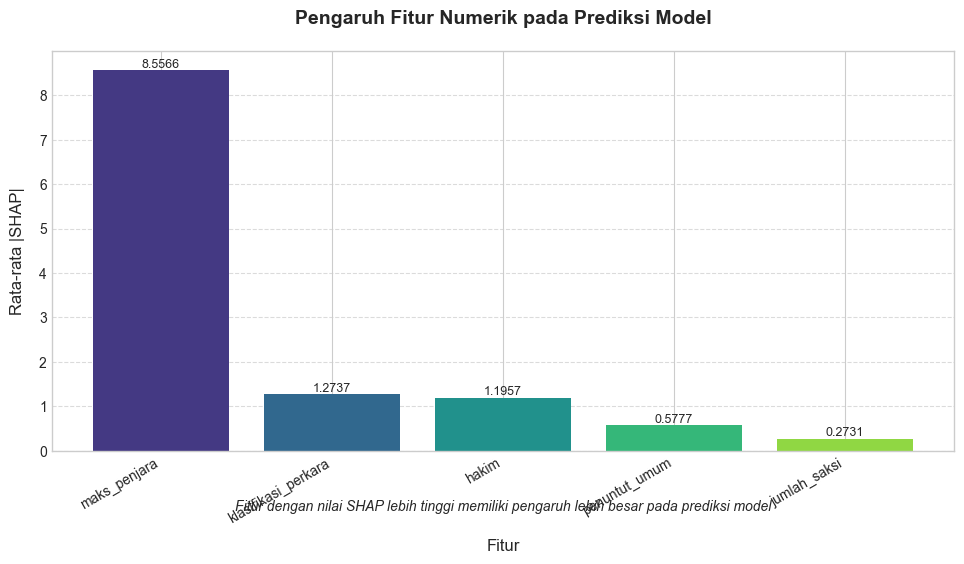


               TOP 20 TOKEN PALING BERPENGARUH
TOKEN ID   KATA                 NILAI SHAP     
------------------------------------------------------------
70         seharga              0.40800
130        kepolisian           0.39020
134        barangbarang         0.32686
85         kunci                0.29292
119        harga                0.28702
2          narkotika            0.28570
7          ayat                 0.28077
141        oktob                0.27973
69         ii                   0.27019
74         laboratorium         0.26403
16         kuhp                 0.25601
11         sabu                 0.25048
52         pencurian            0.24986
80         gianyar              0.24880
1          terdakwa             0.24243
115        total                0.24165
88         kelurahan            0.23989
125        bernama              0.23977
8          berdasarkan          0.23519
116        komang               0.23331



The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


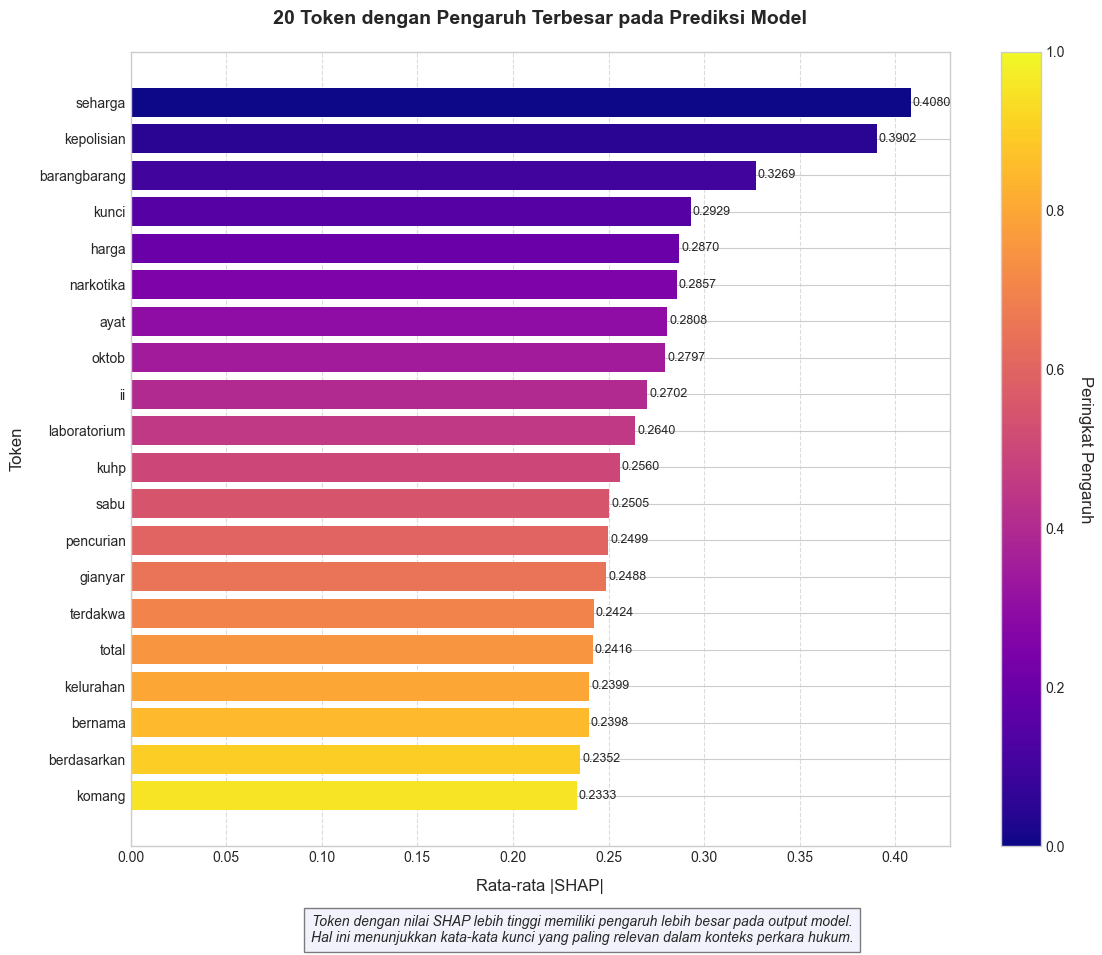

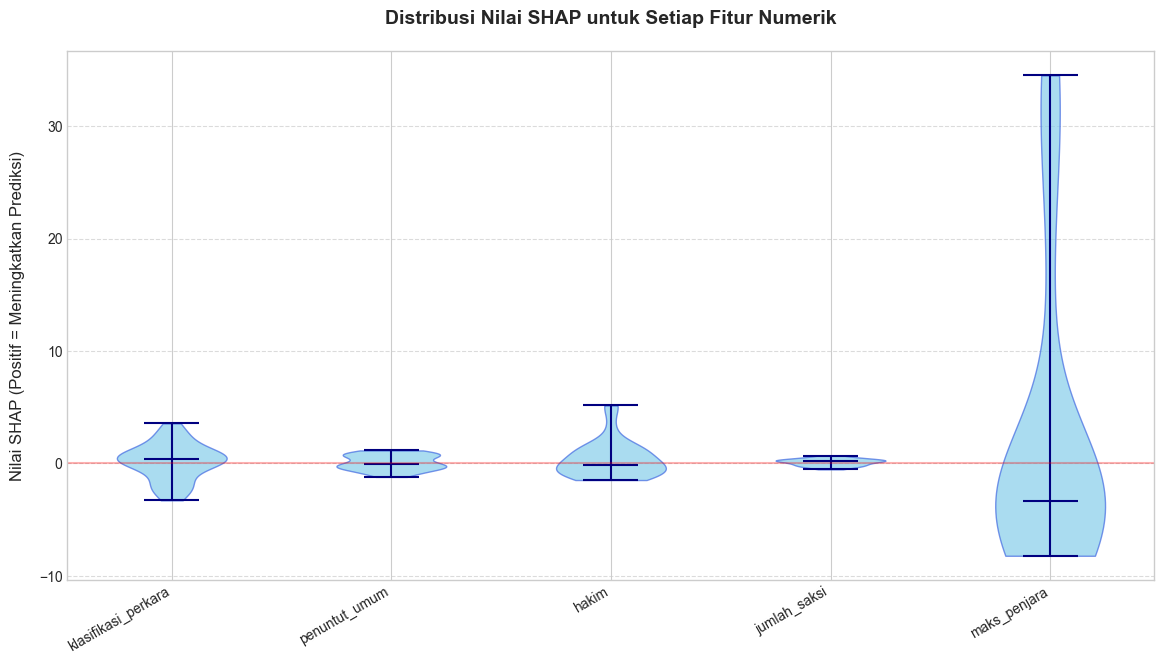

In [29]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")

# Konfigurasi font 
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Fitur numerik saja
shap_num_only = shap_values[0][:, 1024:]  

# Hitung rata-rata absolut SHAP untuk fitur numerik
mean_abs_shap_num = np.mean(np.abs(shap_num_only), axis=0)

# Nama fitur numerik
feature_names_num = ['klasifikasi_perkara', 'penuntut_umum', 'hakim', 'jumlah_saksi', 'maks_penjara']

# Urutkan fitur berdasarkan nilai SHAP
sorted_idx = np.argsort(mean_abs_shap_num)[::-1]
sorted_feature_names = [feature_names_num[i] for i in sorted_idx]
sorted_values = mean_abs_shap_num[sorted_idx]

# warna gradien
colors = sns.color_palette("viridis", len(feature_names_num))

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(range(len(sorted_feature_names)), sorted_values, color=colors)

# nilai di atas bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
            f'{height:.4f}', ha='center', va='bottom', fontsize=9, rotation=0)

ax.set_xticks(range(len(sorted_feature_names)))
ax.set_xticklabels(sorted_feature_names, rotation=30, ha='right')
ax.set_title('Pengaruh Fitur Numerik pada Prediksi Model', fontweight='bold', pad=20)
ax.set_xlabel('Fitur', labelpad=10)
ax.set_ylabel('Rata-rata |SHAP|', labelpad=10)

# anotasi dan grid
ax.annotate('Fitur dengan nilai SHAP lebih tinggi memiliki pengaruh lebih besar pada prediksi model', 
            xy=(0.5, -0.15), xycoords='axes fraction', ha='center', fontsize=10, fontstyle='italic')
ax.grid(axis='y', linestyle='--', alpha=0.7)
fig.tight_layout(pad=2)
plt.show()

# Ambil 1024 token pertama (fitur token teks)
shap_token_only = shap_values[0][:, :1024]

# Rata-rata absolut SHAP token
mean_abs_shap_token = np.mean(np.abs(shap_token_only), axis=0)

# Top 20 token dengan pengaruh tertinggi
top_20_idx = np.argsort(mean_abs_shap_token)[-20:][::-1]
top_20_values = mean_abs_shap_token[top_20_idx]

# Mapping token id ke kata dari tokenizer
index_word = tokenizer.index_word
top_20_tokens = [index_word.get(i, "[UNK]") for i in top_20_idx]

# Cetak hasil secara terformat
print("\n" + "="*60)
print(" "*15 + "TOP 20 TOKEN PALING BERPENGARUH")
print("="*60)
print(f"{'TOKEN ID':<10} {'KATA':<20} {'NILAI SHAP':<15}")
print("-"*60)
for idx, token, val in zip(top_20_idx, top_20_tokens, top_20_values):
    print(f"{idx:<10} {token:<20} {val:.5f}")
print("="*60 + "\n")

# colormap
cmap = plt.cm.get_cmap('plasma')
colors = [cmap(i/len(top_20_tokens)) for i in range(len(top_20_tokens))]

# Plot horizontal bar untuk top token
fig, ax = plt.subplots(figsize=(12, 10))
bars = ax.barh(range(len(top_20_tokens)), top_20_values, color=colors)

# Tambahkan nilai pada bar
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width + 0.001, bar.get_y() + bar.get_height()/2,
            f'{width:.4f}', ha='left', va='center', fontsize=9)

# sumbu y terbalik sehingga token tertinggi di atas
ax.set_yticks(range(len(top_20_tokens)))
ax.set_yticklabels(top_20_tokens)
ax.invert_yaxis()

# gradien warna sebagai legenda
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Peringkat Pengaruh', rotation=270, labelpad=20)

ax.set_title('20 Token dengan Pengaruh Terbesar pada Prediksi Model', fontweight='bold', pad=20)
ax.set_xlabel('Rata-rata |SHAP|', labelpad=10)
ax.set_ylabel('Token', labelpad=10)
ax.grid(axis='x', linestyle='--', alpha=0.7)

# anotasi penjelasan
plt.figtext(0.5, 0.01, 
            "Token dengan nilai SHAP lebih tinggi memiliki pengaruh lebih besar pada output model.\n"
            "Hal ini menunjukkan kata-kata kunci yang paling relevan dalam konteks perkara hukum.",
            ha="center", fontsize=10, fontstyle='italic', bbox={"facecolor":"lavender", "alpha":0.5, "pad":5})

fig.tight_layout(rect=[0, 0.03, 1, 0.97], pad=2)
plt.show()


# plot violin untuk melihat distribusi nilai SHAP untuk fitur numerik
fig, ax = plt.subplots(figsize=(12, 7))
data_to_plot = []
for i in range(shap_num_only.shape[1]):
    data_to_plot.append(shap_num_only[:, i])

violin_parts = ax.violinplot(data_to_plot, showmedians=True)

# Kustomisasi violin plot
for pc in violin_parts['bodies']:
    pc.set_facecolor('skyblue')
    pc.set_edgecolor('royalblue')
    pc.set_alpha(0.7)

for partname in ['cbars', 'cmins', 'cmaxes', 'cmedians']:
    vp = violin_parts[partname]
    vp.set_edgecolor('navy')
    vp.set_linewidth(1.5)

ax.set_xticks(range(1, len(feature_names_num) + 1))
ax.set_xticklabels(feature_names_num, rotation=30, ha='right')
ax.set_title('Distribusi Nilai SHAP untuk Setiap Fitur Numerik', fontweight='bold', pad=20)
ax.set_ylabel('Nilai SHAP (Positif = Meningkatkan Prediksi)', labelpad=10)
ax.axhline(y=0, color='r', linestyle='-', alpha=0.3)
ax.grid(axis='y', linestyle='--', alpha=0.7)

fig.tight_layout(pad=2)
plt.show()